<a href="https://colab.research.google.com/github/xanasa14/MLImplementations/blob/master/ToxicComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re
import nltk 

import matplotlib.pyplot as plt

In [102]:
#toxic_comments = pd.read_csv("/content/train.csv",engine='python',encoding='utf-8')
toxic_comments = pd.read_csv("/content/drive/MyDrive/toxicCommentz/train.csv")

print(toxic_comments.head())

print(toxic_comments.tail)

                 id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]
<bound method NDFrame.tail of                       id  ... identity_hate
0       0000997932d777bf  ...             0
1       000103f0d9cfb60f  ...             0
2       000113f07ec002fd  ...             0
3       0001b41b1c6bb37e  ...             0
4       0001d958c54c6e35  ...             0
...                  ...  ...           ...
159566  ffe987279560d7ff  ...             0
159567  ffea4adeee384e90  ...             0
159568  ffee36eab5c267c9  ...             0
159569  fff125370e4aaaf3  ...             0
159570  fff46fc426af1f9a  ...             0

[159571 rows x 8 columns]>


In [103]:
print(toxic_comments['comment_text'].head())
print(toxic_comments.shape)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object
(159571, 8)


In [104]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()
print(toxic_comments["comment_text"][168])


You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [105]:
counter = 0
offensive = []
nonOffensive = []
for i in range(len(toxic_comments)):
  #if (i <= 500):
  if (int(toxic_comments["toxic"][i]) == 1 or int(toxic_comments["severe_toxic"][i]) == 1 or 
      int(toxic_comments["obscene"][i]) == 1 or int(toxic_comments["threat"][i]) == 1 or
      int(toxic_comments["insult"][i]) == 1 or int(toxic_comments["identity_hate"][i]) == 1):
    #print("Toxic:" + str(toxic_comments["toxic"][i]))
    #print("Severe_toxic:" + str(toxic_comments["severe_toxic"][i]))
    #print("Obscene:" + str(toxic_comments["obscene"][i]))
    #print("Threat:" + str(toxic_comments["threat"][i]))
    #print("Insult:" + str(toxic_comments["insult"][i]))
    #print("Identity_hate:" + str(toxic_comments["identity_hate"][i]))
    offensive.append(1)
    nonOffensive.append(0)
  else: 
    nonOffensive.append(1)
    offensive.append(0)

# Declare a list that is to be converted into a column 

  
# Using 'Address' as the column name 
# and equating it to the list 
toxic_comments['offensive'] = offensive
toxic_comments['nonOffensive'] = nonOffensive


#toxic_comments = toxic_comments[toxic_comments.offensive == 1]


In [106]:
print("comment_text:" + str(toxic_comments["comment_text"][0]))

print("Toxic:" + str(toxic_comments["toxic"][0]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][0]))
print("Obscene:" + str(toxic_comments["obscene"][0]))
print("Threat:" + str(toxic_comments["threat"][0]))
print("Insult:" + str(toxic_comments["insult"][0]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][0]))


len(toxic_comments)
print("Offensive :" + str (toxic_comments['offensive'][0]))
print("Non-offensive :" + str (toxic_comments['nonOffensive'][0]))

comment_text:Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Toxic:0
Severe_toxic:0
Obscene:0
Threat:0
Insult:0
Identity_hate:0
Offensive :0
Non-offensive :1


In [107]:
#toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels = toxic_comments[["offensive", "nonOffensive"]]

toxic_comments_OffensiveOrNot = toxic_comments[["comment_text","offensive", "nonOffensive"]]
print(toxic_comments_OffensiveOrNot["offensive"][168])
print(toxic_comments_OffensiveOrNot["comment_text"][168])

1
You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


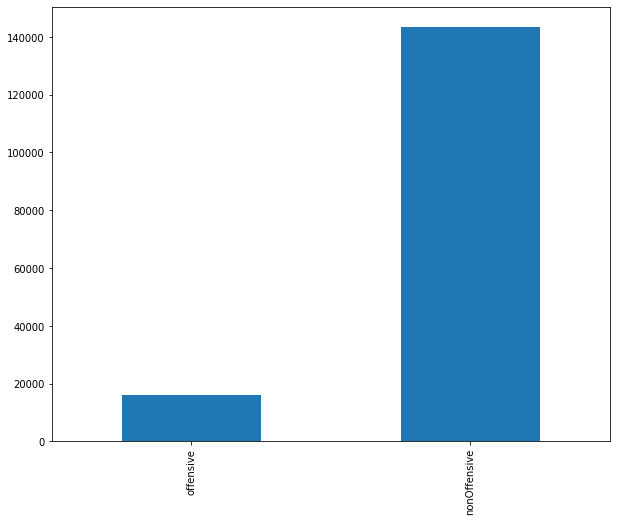

In [108]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [117]:
import spacy

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load('en', disable=['parser', 'ner'])
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
import string  
#Removing punctuationes and those characters
def remove_punctuations(text):
  for punctuation in string.punctuation:
      text = text.replace(punctuation, '')
  return text
# Lowering Text from DataFrame
def loweringText(text):
    text = text.lower()
    return text
#Remove stopwords : words that do not put as much significance or impact as other words in the description
def remove_StopWords(text):
  line = text.split()
  text = ""
  for word in line:
    if(word not in stop_words):
      text += word
      text += " "
  return text
#Implementing lemmatization words by word
def lemmatize(text):
  line = text.split()
  txt = ""
  for word in line:
    doc = nlp(word)
    for token in doc:
      txt += token.lemma_
      txt += " "
  return txt




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
toxic_comments["comment_text_  X"] = toxic_comments['comment_text'].apply(remove_punctuations).apply(loweringText).apply(remove_StopWords).apply(lemmatize)


In [109]:
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data)
    data = re.sub(r"\n", "", data)
    data = re.sub(r".jpeg", "", data) 

     
    return data


toxic_comments_OffensiveOrNot['comment_text']=toxic_comments_OffensiveOrNot['comment_text'].apply(lambda z: remove_abb(z))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [110]:
%%time
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

def lemma_traincorpus(text):
    lemm_words = " ".join([lemm.lemmatize(word) for word in text.split()])    
    return lemm_words
                        


toxic_comments_OffensiveOrNot['comment_text']=toxic_comments_OffensiveOrNot['comment_text'].apply(lambda z: lemma_traincorpus(z))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
CPU times: user 33.8 s, sys: 129 ms, total: 33.9 s
Wall time: 34 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [111]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [99]:
X = []
#toxic_comments_labels = toxic_comments[["offensive"]]

sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values


In [100]:
sentences [10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [77]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [78]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

#glove_file = open('/content/drive/My Drive/Colab Datasets/glove.6B.100d.txt', encoding="utf8")
glove_file = open('/content/drive/MyDrive/gloves/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [79]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(2, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [80]:
print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          12592400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 12,709,906
Trainable params: 117,506
Non-trainable params: 12,592,400
_________________________________________________________________
None


In [81]:
history = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1, validation_split=0.4)

Epoch 1/7
449/449 [==============================] - 295s 653ms/step - loss: 0.3582 - acc: 0.8966 - val_loss: 0.3278 - val_acc: 0.8974
Epoch 2/7
449/449 [==============================] - 289s 644ms/step - loss: 0.2978 - acc: 0.8988 - val_loss: 0.3009 - val_acc: 0.8974
Epoch 3/7
449/449 [==============================] - 288s 642ms/step - loss: 0.2972 - acc: 0.8997 - val_loss: 0.3311 - val_acc: 0.8971
Epoch 4/7
449/449 [==============================] - 291s 649ms/step - loss: 0.3104 - acc: 0.9020 - val_loss: 0.1994 - val_acc: 0.9177
Epoch 5/7
449/449 [==============================] - 289s 644ms/step - loss: 0.1909 - acc: 0.9325 - val_loss: 0.1564 - val_acc: 0.9454
Epoch 6/7
449/449 [==============================] - 295s 656ms/step - loss: 0.1458 - acc: 0.9497 - val_loss: 0.1439 - val_acc: 0.9497
Epoch 7/7
449/449 [==============================] - 295s 658ms/step - loss: 0.1331 - acc: 0.9532 - val_loss: 0.1379 - val_acc: 0.9497


In [83]:
score = history.model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1995/1995 [==============================] - 90s 45ms/step - loss: 0.1350 - acc: 0.9509
Test Score: 0.13497868180274963
Test Accuracy: 0.9509313702583313


In [84]:

print(X_test.shape)
print(y_test.shape)

print(score)
toxic_comments_labels.values



(63829, 200)
(63829, 2)
[0.13497868180274963, 0.9509313702583313]


array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [85]:
history.model.predict

<bound method Model.predict of <tensorflow.python.keras.engine.functional.Functional object at 0x7fca81c1fef0>>

In [86]:
model.save('/content/drive/MyDrive/toxicCommentz/my_model.h5')
# LOAD 
import keras
model = keras.models.load_model('/content/drive/MyDrive/toxicCommentz/my_model.h5')



In [87]:
y_pred = history.model.predict(X_test)
print(y_pred)
print(y_test)
print(y_pred.shape)
print(y_test.shape)

[[0.07213622 0.9299003 ]
 [0.00406942 0.9958745 ]
 [0.02869672 0.97261024]
 ...
 [0.09316707 0.9099903 ]
 [0.04185426 0.96698403]
 [0.06164894 0.9387214 ]]
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [0 1]]
(63829, 2)
(63829, 2)


In [88]:
print(len(y_pred))
print(len(y_test))

63829
63829


In [89]:


import sklearn.metrics as metrics
from sklearn.metrics import classification_report
target_names= ["Offensive" , "NonOffensive"]
print(classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), target_names=target_names))


matrix = metrics.confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1),)


              precision    recall  f1-score   support

   Offensive       0.57      0.92      0.70      4032
NonOffensive       0.99      0.95      0.97     59797

    accuracy                           0.95     63829
   macro avg       0.78      0.94      0.84     63829
weighted avg       0.97      0.95      0.96     63829



In [90]:
matrix

array([[ 3723,   309],
       [ 2823, 56974]])

In [91]:
print(y_pred.shape)
y_pred2 = y_pred
y_test2 = y_test

Size = len (y_test2)

y_test2 = y_test2.reshape((Size,-1))
y_pred2 = y_pred2.reshape((Size,-1))


print(y_pred2.shape)
print(y_test2.shape)

matrix = metrics.confusion_matrix(y_pred2.argmax(axis=1), y_test2.argmax(axis=1))


(63829, 2)
(63829, 2)
(63829, 2)


In [92]:
matrix

array([[ 3723,   309],
       [ 2823, 56974]])

In [93]:
CR = metrics.accuracy_score(y_pred2.argmax(axis=1), y_test2.argmax(axis=1))
print(CR)

0.9509313948205361


In [94]:
#WIthout Lemma and Abba
             precision    recall  f1-score   support

   Offensive       0.01      0.90      0.02        80
NonOffensive       1.00      0.90      0.95     63749

    accuracy                           0.90     63829
   macro avg       0.51      0.90      0.48     63829
weighted avg       1.00      0.90      0.95     63829


0.8984474141847749
array([[   72,     8],
       [ 6474, 57275]])

SyntaxError: ignored

In [ ]:
              precision    recall  f1-score   support

   Offensive       0.57      0.92      0.70      4032
NonOffensive       0.99      0.95      0.97     59797

    accuracy                           0.95     63829
   macro avg       0.78      0.94      0.84     63829
weighted avg       0.97      0.95      0.96     63829

0.9509313948205361
